# Análisis Exploratorio de Datos (EDA- Sobre los datos limpios):

A partir de los datos limpios guardados en la carpeta "Clean_Data" podremos realizar un análisis más preceiso sobre los datos con relación las consultas y fórmulas de los endpointsrequeridos y el modelo recomendación.

### 1. Importación de librerías necesarias para realizar el EDA:

In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt



### 2. EDA del archivo "SGames_CD" (steam Games):

### 2.1. Abrir el archivo:

In [2]:
SGames_CD= pd.read_csv('Clean_Data\SGames_CD.csv')
SGames_CD.head(2)

,publisher,genres,app_name,release_date,specs,price,early_access,id,developer,release_year
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,2018-01-04,['Single-player'],4.99,False,761140.0,Kotoshiro,2018
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,2018-01-04,"['Single-player', 'Multi-player', 'Online Mult...",0.00,False,643980.0,Secret Level SRL,2018


### 2.2. Verificar si se deben expandir las columnas con listas:

Este archivo se usará en el modelo de recomendación y sería bueno extender y codificar "genres" y "specs", pero antes de esto debemos verificar a cuanros géneros realmente podrían existir en las bases de datos.

### 2.2.1. Verificación de la columna "genres":

In [3]:
# Convierte las cadenas que representan listas a listas reales
Generos = SGames_CD['genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# Obtiene combinaciones únicas de géneros
combinaciones_unicas_genero = Generos.apply(pd.Series).stack().unique()

# Inicializa una lista para almacenar los valores únicos
valores_unicos_genero = []

# Itera sobre las combinaciones únicas
for i in combinaciones_unicas_genero:
    if i in valores_unicos_genero:
        continue  # Si el valor ya está en la lista, continúa con la siguiente iteración
    else:
        valores_unicos_genero.append(i)

# Imprime los valores únicos
print(valores_unicos_genero)


['Action', 'Casual', 'Indie', 'Simulation', 'Strategy', 'Free to Play', 'RPG', 'Sports', 'Adventure', 'Racing', 'Early Access', 'VR', 'Design & Illustration', 'Tutorial', 'Massively Multiplayer', 'Education', 'Golf', 'Horror', 'Lovecraftian', 'Survival Horror', 'First-Person', 'Based On A Novel', 'FPS', 'Atmospheric', 'Stealth', 'Singleplayer', 'Story Rich', 'Classic', 'Survival', 'Shooter', 'Difficult', 'Gore', 'Dark', 'Open World', 'Fantasy', 'Moddable', 'Exploration', 'Great Soundtrack', 'Magic', 'Sandbox', 'Character Customization', 'Medieval', 'Action RPG', 'Third Person', 'Dark Fantasy', 'RTS', 'Surreal', 'Real-Time', 'Multiplayer', 'Hidden Object', 'Female Protagonist', 'Puzzle', 'Platformer', 'Isometric', '3D Platformer', 'Retro', 'Arcade', '2D', 'Cyberpunk', 'Replay Value', 'Fast-Paced', "1990's", 'Family Friendly', 'Colorful', 'Local Multiplayer', 'Local Co-Op', 'Co-op', 'Pixel Graphics', 'JRPG', 'Sci-fi', 'Ninja', 'Anime', 'Metroidvania', 'Side Scroller', 'Animation &amp; Mo

In [4]:
print('existen ', len(valores_unicos_genero),' géneros distintos')

existen  303  géneros distintos


De los anterior tenemos 303 generos distintos, que se presumen demasiados a la hora de normalizar una tabla de géneros con el "id" del juego (crear una tabla auxiliar que tengan los generos expandidos con "id"), esto craría miles de filas. así que acontinuación revisaremos cuantas combinaciones únicas de género hay:

In [5]:
# Suponiendo que tu DataFrame se llama df_Steam_Games y la columna es 'genre'
valores_combinados_unicos = SGames_CD['genres'].explode().unique()
print(valores_combinados_unicos)
print('existen ', len(valores_combinados_unicos),' combinaciones de géneros')

["['Action', 'Casual', 'Indie', 'Simulation', 'Strategy']"
 "['Free to Play', 'Indie', 'RPG', 'Strategy']"
 "['Casual', 'Free to Play', 'Indie', 'Simulation', 'Sports']" ...
 "['Early Access', 'Casual']"
 "['Video Production', 'Utilities', 'Web Publishing']"
 "['Early Access', 'Adventure', 'Indie', 'Action', 'Simulation', 'VR']"]
existen  2682  combinaciones de géneros


Se observa que hay 2682 combinaciones de géneros que siguen siendo demasiadas, pero no aumentan los registros si los dejamos tal cual como están; pero se realizará un análisis sobre los generos expandidos para investigar si los datos se acumulan en un top princilpal más adeacuado de manejar:

A continuación cramos un datafrome auxiliar que tenga los generos conservando el "id" de los videojuegos:

In [6]:
# Convertir "genres" en una verdadera lista:
SGames_CD['genres'] = SGames_CD['genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# Crear un DataFrame auxiliar solo con las columnas 'id' y 'genres'
df_genres_auxiliar = SGames_CD[['id', 'genres']]

# Expandir la columna 'genres' en filas
df_genres_expanded = df_genres_auxiliar.explode('genres')

# Imprimir el DataFrame expandido
print(df_genres_expanded)


             id      genres
0      761140.0      Action
0      761140.0      Casual
0      761140.0       Indie
0      761140.0  Simulation
0      761140.0    Strategy
...         ...         ...
32132  681550.0   Adventure
32132  681550.0       Indie
32132  681550.0      Action
32132  681550.0  Simulation
32132  681550.0          VR

[85628 rows x 2 columns]


Se obtienen 85628 registros. A continuación se realiza un gráfico de Pareto para verificar si existe una tendencia en acumular los viedeojuegos en "generos" principales:

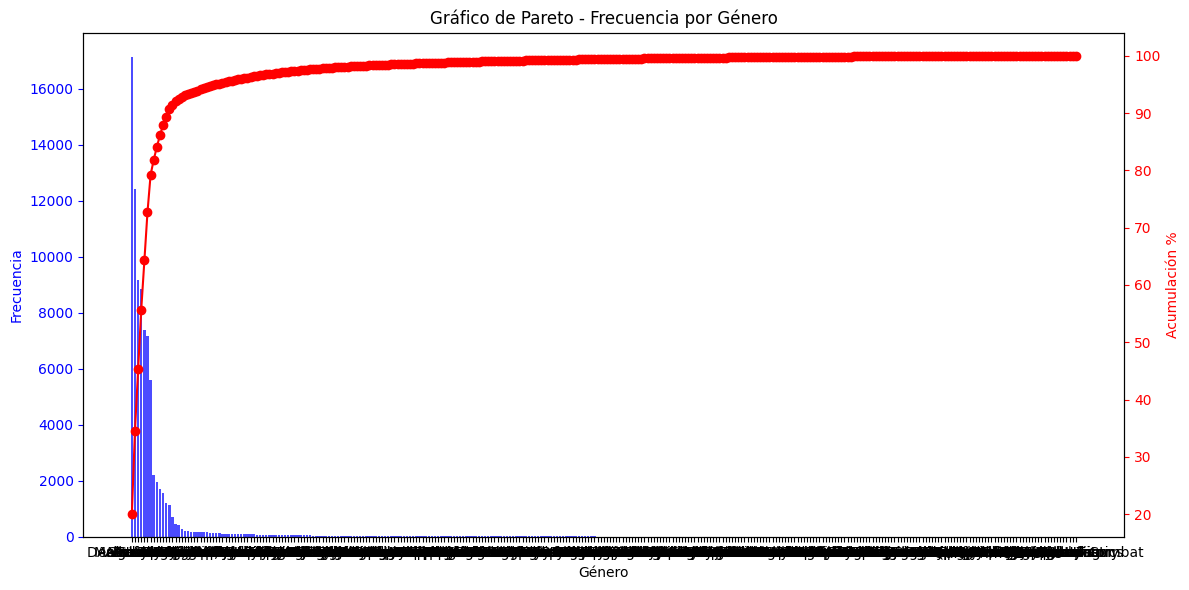

In [7]:
# Obtener la frecuencia de cada género
frecuencia_generos = df_genres_expanded['genres'].value_counts()

# Calcular la acumulación porcentual
acumulacion_porcentual = frecuencia_generos.cumsum() / frecuencia_generos.sum() * 100

# Crear el gráfico de Pareto
fig, ax1 = plt.subplots(figsize=(12, 6))

# Barra de frecuencias
ax1.bar(frecuencia_generos.index, frecuencia_generos, color='b', alpha=0.7, label='Frecuencia')

# Eje y izquierdo para las barras
ax1.set_xlabel('Género')
ax1.set_ylabel('Frecuencia', color='b')
ax1.tick_params('y', colors='b')

# Eje y derecho para la acumulación porcentual
ax2 = ax1.twinx()
ax2.plot(frecuencia_generos.index, acumulacion_porcentual, color='r', marker='o', label='Acumulación %')
ax2.set_ylabel('Acumulación %', color='r')
ax2.tick_params('y', colors='r')

# Título y leyendas
plt.title('Gráfico de Pareto - Frecuencia por Género')
fig.tight_layout()
plt.show()


Evidentemente existen géneros principales en los cuales se acumula el 90% de los registros. Una buena noticia para disminuir el dataframe auxiliar "df_genres_expanded". A continuación se verifica los géneros priniciplaes:

In [8]:
acumulacion_porcentual[acumulacion_porcentual <= 90]

genres
Indie           20.047024
Action          34.588076
Casual          45.301735
Adventure       55.659792
Simulation      64.293652
Strategy        72.673677
RPG             79.235925
Free to Play    81.825732
Early Access    84.103218
VR              86.112833
Sports          87.923593
Racing          89.316754
Name: count, dtype: float64

Se toma el df_genres_expanded y se cambia cualquier genero que no se principal por la palabra "others" para verificar si al elimnar duplicados, esto es realmente considerable y significativo para continuar con la idea de expandir la columna "genres":

In [9]:
# Aplicar filtro para incluir solo los géneros que acumulan hasta el 90%
generos_hasta_90 = acumulacion_porcentual[acumulacion_porcentual <= 90].index

# Modificar df_genres_expanded para conservar solo los géneros hasta el 90% y cambiar los demás por 'others'
df_genres_expanded['genres'] = df_genres_expanded['genres'].where(df_genres_expanded['genres'].isin(generos_hasta_90), 'others')

# Eliminar duplicados basándote en la combinación de 'id' y 'genres'
df_genres_expanded = df_genres_expanded.drop_duplicates(subset=['id', 'genres'])

In [10]:
# Verificar el DataFrame modificado
df_genres_expanded

,id,genres
0,761140.0,Action
0,761140.0,Casual
0,761140.0,Indie
0,761140.0,Simulation
0,761140.0,Strategy
...,...,...
32132,681550.0,Adventure
32132,681550.0,Indie
32132,681550.0,Action
32132,681550.0,Simulation


La disminución de registros no fué tan alta; así que lo mejor para trabajar el modelo de recomendación "item - item" será trabajar los generos combinados, sin embargo se guardará este datafrome auxiliar para los cálculos de algunos endpoints.

A continuación se guarda el dataframe auxiliar en la carpeta Clean_Data:

In [11]:
# Exportar el DataFrame a CSV
df_genres_expanded.to_csv('Clean_Data/Genres_Items.csv', index=False)

print(f"DataFrame exportado a {'Clean_Data/Genres_Items.csv'}")

DataFrame exportado a Clean_Data/Genres_Items.csv


### 2.2.2. Verificación sobre la columna "specs":

In [12]:
# Convierte las cadenas que representan listas a listas reales
Specs = SGames_CD['specs'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# Obtiene combinaciones únicas de géneros
combinaciones_unicas_specs= Specs.apply(pd.Series).stack().unique()

# Inicializa una lista para almacenar los valores únicos
valores_unicos_specs = []

# Itera sobre las combinaciones únicas
for i in combinaciones_unicas_specs:
    if i in valores_unicos_specs:
        continue  # Si el valor ya está en la lista, continúa con la siguiente iteración
    else:
        valores_unicos_specs.append(i)

# Imprime los valores únicos
print(valores_unicos_specs)

['Single-player', 'Multi-player', 'Online Multi-Player', 'Cross-Platform Multiplayer', 'Steam Achievements', 'Steam Trading Cards', 'In-App Purchases', 'Stats', 'Full controller support', 'HTC Vive', 'Oculus Rift', 'Tracked Motion Controllers', 'Room-Scale', 'Downloadable Content', 'Steam Cloud', 'Steam Leaderboards', 'Partial Controller Support', 'Seated', 'Standing', 'Local Co-op', 'Shared/Split Screen', 'Valve Anti-Cheat enabled', 'Local Multi-Player', 'Steam Turn Notifications', 'MMO', 'Co-op', 'Online Co-op', 'Captions available', 'Commentary available', 'Steam Workshop', 'Includes level editor', 'Mods', 'Mods (require HL2)', 'Game demo', 'Includes Source SDK', 'SteamVR Collectibles', 'Keyboard / Mouse', 'Gamepad', 'Windows Mixed Reality', 'Mods (require HL1)']


In [13]:
print('existen ', len(valores_unicos_specs),' especificaciones')

existen  40  especificaciones


Como no se tiene de objetivo crear endpoints asociados a esta columna, dejaremos la columna como está para no generar más tablas ni registros. Ya que como están podrían favorecer el modelo de recomendación "item -item".

### 2.3. Verificar el número de video juegos por género:

In [14]:
# Obtener la frecuencia de cada género
frecuencia_generos = df_genres_expanded['genres'].value_counts()

# Calcular la acumulación porcentual
acumulacion_porcentual = frecuencia_generos.cumsum() / frecuencia_generos.sum() * 100

In [15]:
acumulacion_porcentual

genres
Indie            21.313535
Action           36.773247
Casual           48.163763
Adventure        59.176212
Simulation       68.355532
Strategy         77.264983
RPG              84.241814
others           89.282294
Free to Play     92.035717
Early Access     94.457088
VR               96.593665
Sports           98.518823
Racing          100.000000
Name: count, dtype: float64

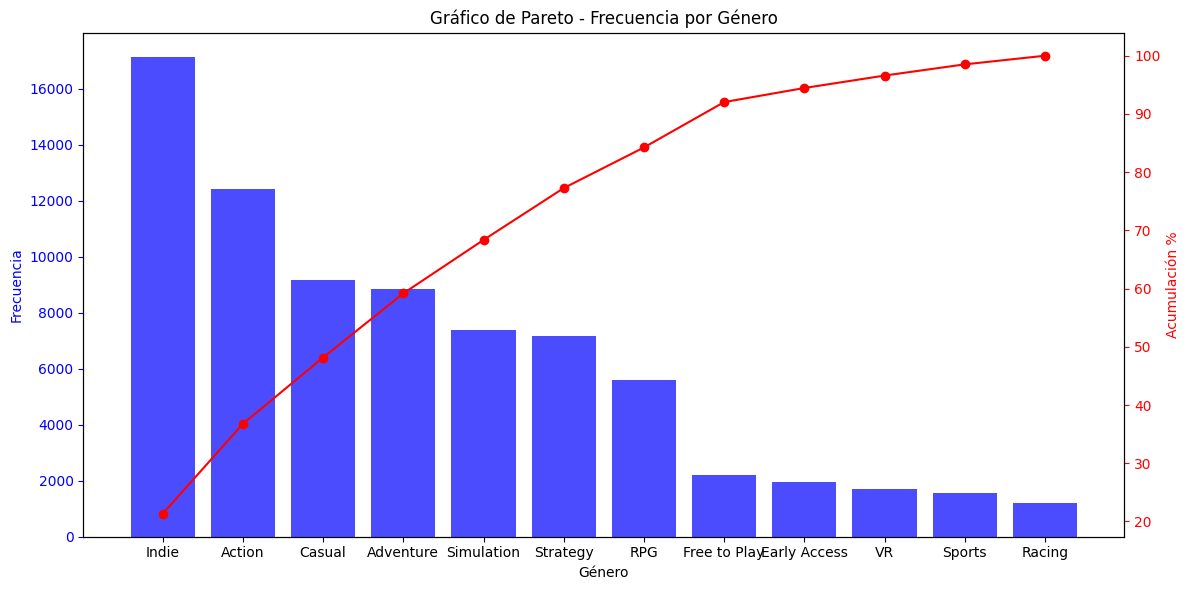

In [16]:
# Crear el gráfico de Pareto solo para los géneros que acumulan hasta el 90%
fig, ax1 = plt.subplots(figsize=(12, 6))

# Barra de frecuencias
ax1.bar(generos_hasta_90, frecuencia_generos[generos_hasta_90], color='b', alpha=0.7, label='Frecuencia')

# Eje y izquierdo para las barras
ax1.set_xlabel('Género')
ax1.set_ylabel('Frecuencia', color='b')
ax1.tick_params('y', colors='b')

# Eje y derecho para la acumulación porcentual
ax2 = ax1.twinx()
ax2.plot(generos_hasta_90, acumulacion_porcentual[generos_hasta_90], color='r', marker='o', label='Acumulación %')
ax2.set_ylabel('Acumulación %', color='r')
ax2.tick_params('y', colors='r')

# Rotar las etiquetas del eje x en forma vertical
plt.xticks(rotation='vertical')

# Título y leyendas
plt.title('Gráfico de Pareto - Frecuencia por Género')

fig.tight_layout()
plt.show()


Observamos que al separar los datos el género más jugado es Indie, con los datos combinados el videojuego más jugado en Action. Esto se revisa a continuación:

In [17]:
SGames_CD['genres'].describe()


count        32133
unique        2682
top       [Action]
freq          1882
Name: genres, dtype: object

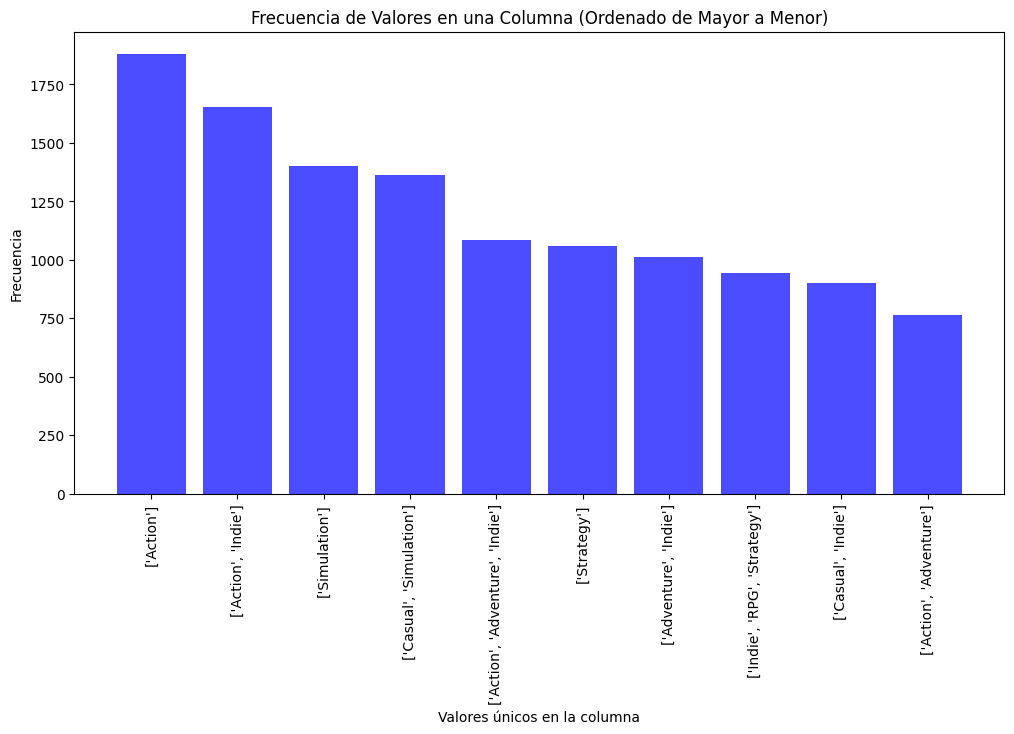

In [18]:

# Reemplaza 'genres' con el nombre de tu columna real
SGames_CD['genres'] = SGames_CD['genres'].astype(str)

# Obtener la frecuencia de cada valor en la columna
frecuencia_columna = SGames_CD['genres'].value_counts().head(10)

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(frecuencia_columna.index, frecuencia_columna, color='b', alpha=0.7)
plt.xlabel('Valores únicos en la columna')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Valores en una Columna (Ordenado de Mayor a Menor)')
plt.xticks(rotation='vertical')  # Rotar las etiquetas del eje x en forma vertical
plt.show()

### 2.4. Verificar el número de video juegos por año de lanzamiento:

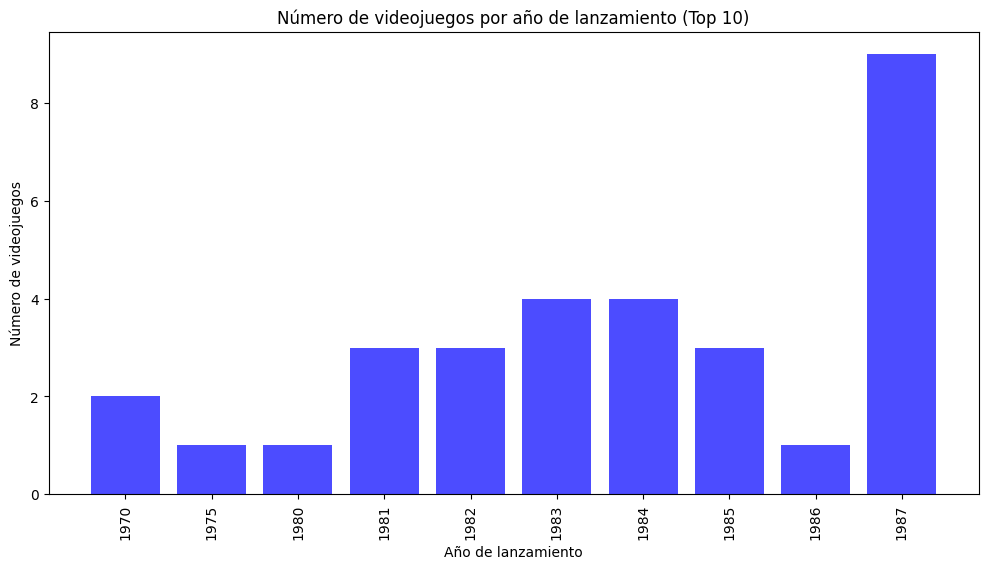

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Suponiendo que tu DataFrame se llama SGames_CD y la columna es 'release_year'
# Reemplaza 'release_year' con el nombre de tu columna real
SGames_CD['release_year'] = SGames_CD['release_year'].astype(str)

# Filtrar los datos donde el año no sea 0
SGames_CD_filtered = SGames_CD[SGames_CD['release_year'] != '0']

# Obtener la frecuencia de cada valor en la columna y ordenar de menor a mayor año
frecuencia_columna = SGames_CD_filtered['release_year'].value_counts().sort_index().head(10)

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(frecuencia_columna.index, frecuencia_columna, color='b', alpha=0.7)
plt.xlabel('Año de lanzamiento')
plt.ylabel('Número de videojuegos')
plt.title('Número de videojuegos por año de lanzamiento (Top 10)')
plt.xticks(rotation='vertical')  # Rotar las etiquetas del eje x en forma vertical
plt.show()


### 3. EDA del archivo "UItems" (User_Items):

### 3.1. Abrir archivo:

In [20]:
# Especificar el carácter de comillas para manejar nombres con dos puntos
UItems = pd.read_csv('Clean_Data\\UItems_CD.csv', quotechar='"')

# Mostrar las primeras filas del DataFrame
UItems.head(2)


,user_id,item_id,playtime_forever,playtime_2weeks
0,76561197970982479,10,6,0
1,76561197970982479,20,0,0


### 3.2. Número de juegos más jugados:

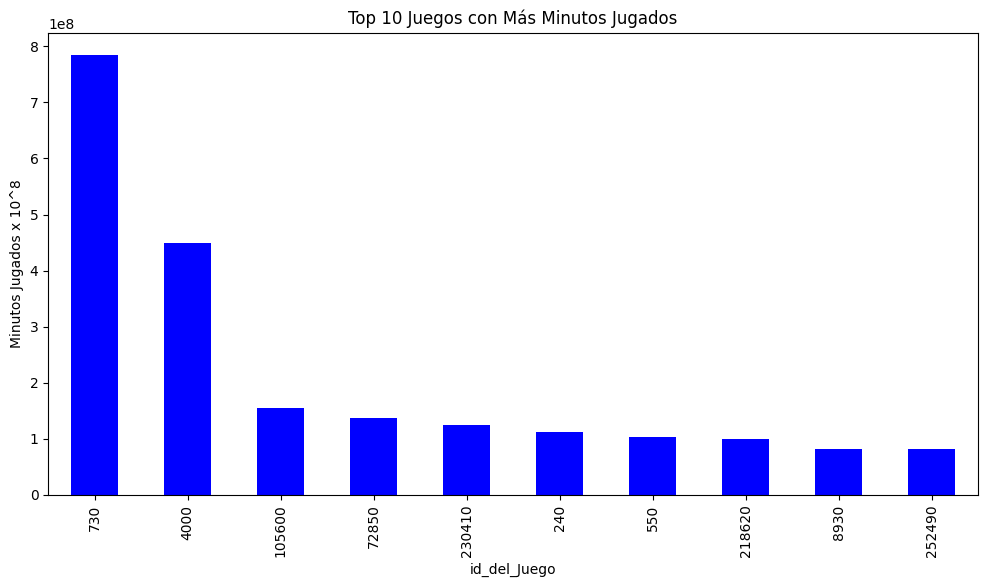

In [21]:
# Agrupar por nombre del juego y sumar los minutos jugados
top_juegos = UItems.groupby('item_id')['playtime_forever'].sum().sort_values(ascending=False).head(10)

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
top_juegos.plot(kind='bar', color='blue')
plt.xlabel('id_del_Juego')
plt.ylabel('Minutos Jugados x 10^8')
plt.title('Top 10 Juegos con Más Minutos Jugados')
plt.xticks(rotation='vertical')  # Rotar las etiquetas del eje x en forma vertical
plt.show()

In [22]:
UItems.groupby('item_id')['playtime_forever'].sum().sort_values(ascending=False).head(100)

item_id
730       785184267
4000      448366616
105600    154974541
72850     136678626
230410    124027703
            ...    
255710      7582614
39210       7562552
205100      7512341
9900        7464778
39120       7437432
Name: playtime_forever, Length: 100, dtype: int64

### 4. EDA del archivo "UReviews" (User_Reviews):

### 4.1. Abrir archivo:

In [23]:
# Especificar el carácter de comillas para manejar nombres con dos puntos
UReviews = pd.read_csv('Clean_Data\\UReviews_CD.csv', quotechar='"')

# Mostrar las primeras filas del DataFrame
UReviews.head(2)

,user_id,item_id,recommend,sentiment_analysis,posted_year
0,76561197970982479,1250,True,2,2011
1,76561197970982479,22200,True,2,2011


Verificar relación con el dataframe SGames:

In [24]:
# Paso 1: Filtrar valores únicos en SGames
df_unique_SGames = SGames_CD[['id', 'app_name']].drop_duplicates()

# Paso 2: Contar la cantidad de veces que cada item_id tiene sentiment_analysis igual a 2 por posted_year
count_sentiment_2_by_year = UReviews[UReviews['sentiment_analysis'] == 2].groupby(['item_id', 'posted_year']).size()

# Paso 3: Encontrar el item_id con la mayor cantidad de ocurrencias de sentiment_analysis igual a 2 por posted_year
max_sentiment_2_item_id_by_year = count_sentiment_2_by_year.groupby('posted_year').idxmax()

# Paso 4: Combina directamente con df_unique_SGames para obtener el app_name y el año
result = df_unique_SGames.loc[[index[1] for index in max_sentiment_2_item_id_by_year.values.flatten()]]

print("El app_name con mejor percepción por año es:")
print('------------------------------------------------')
print(result)


El app_name con mejor percepción por año es:
------------------------------------------------
            id                                           app_name
2010  266370.0                                  Calibre 10 Racing
2011  271468.0       Rocksmith® 2014 – Matchbox Twenty - “Unwell”
2012  258645.0       Train Simulator: Dispolok BR 189 Loco Add-On
2013  273380.0  Total War: ROME II - Hannibal at the Gates Cam...
2014  287740.0                                   The Witch's Yarn
2015  270650.0         Scourge: Outbreak - Blindside PvP Map pack
